<a href="https://colab.research.google.com/github/Texsic/Machine-Learning/blob/main/project_2_nn_from_scratch_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Neural Network from Scratch for MNIST

## Introduction

Welcome to the advanced MLB project 2! In this notebook, you'll build a **Neural Network from scratch** using only NumPy - no TensorFlow or Keras!

### Why Build from Scratch?
- **Deep Understanding**: Learn exactly how neural networks work "under the hood"
- **Master the Math**: Implement forward propagation, backpropagation, and gradient descent yourself
- **Appreciation**: You'll never take `model.fit()` for granted again!

### What You'll Implement:
1. Weight initialization
2. Activation functions (ReLU, Softmax)
3. Forward propagation
4. Loss calculation
5. Backward propagation
6. Gradient descent optimization
7. Full training loop

### Network Architecture:
```
Input (784) → Hidden Layer (128) → Output Layer (10)
```

### TIPS:

- Make sure to call each function at the end of the cell with the correct values!
- This is meant to be VERY challenging, so please don't get discouraged as you work through this. We promise you it's worth it!

## Step 1: Import Libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

np.random.seed(42)
print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.0.2


## Step 2: Load and Preprocess Data

In [44]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]

# Convert labels from strings to integers
y = y.astype(int)

# Normalize the pixel values from [0, 255] to [0, 1]
X = X / 255.0

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data loaded and preprocessed successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Example pixel range: {X_train.min()} - {X_train.max()}")

✅ Data loaded and preprocessed successfully!
Training set shape: (56000, 784)
Test set shape: (14000, 784)
Example pixel range: 0.0 - 1.0


## Step 3: Visualize Sample Data

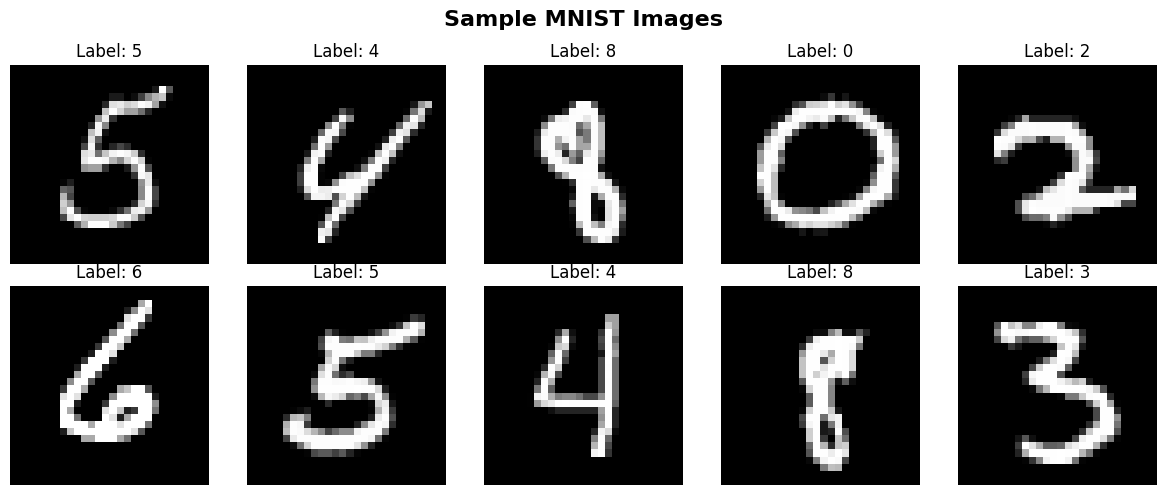

In [45]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.suptitle('Sample MNIST Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4: Activation Functions

In [46]:
# ReLU (Rectified Linear Unit)
def relu(z):
    """
    ReLU activation function: f(z) = max(0, z)
    Introduces non-linearity into the model.
    """
    return np.maximum(0, z)

# Derivative of ReLU (used in backpropagation)
def relu_derivative(z):
    """
    Derivative of ReLU:
    1 if z > 0, else 0
    Important: return float (not boolean)
    """
    return (z > 0).astype(float)

# Softmax activation for output layer
def softmax(z):
    """
    Softmax function converts logits (z) into probabilities.
    Each row of z represents a sample.
    """
    # Numerical stability trick: subtract max for each row
    exp_values = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

print("✅ Activation functions implemented successfully!")

✅ Activation functions implemented successfully!


## Step 5: One-Hot Encoding

We need one-hot encoding because we need the labels, or what is predicted, to match the output format of the NN. If you remember in the NN MLB, we told you that if we are predicted 10 digits, we needed the final layer of the NN to have 10 nodes! By making sure the labels are encoded, we make sure to give the NN a clear format to predict.

Here is a great short video to learn a little more about this: https://www.youtube.com/watch?v=G2iVj7WKDFk

In [47]:
def one_hot_encode(y, num_classes=10):
    """
    Converts a vector of labels (0–9) into one-hot encoded format.
    Example: [2, 0, 3] → [[0,0,1,0,0,0,0,0,0,0],
                           [1,0,0,0,0,0,0,0,0,0],
                           [0,0,0,1,0,0,0,0,0,0]]
    """
    # Create a zero matrix of shape (num_samples, num_classes)
    one_hot = np.zeros((y.size, num_classes))

    # Set the appropriate index to 1 for each sample
    one_hot[np.arange(y.size), y] = 1.0

    return one_hot

# Apply one-hot encoding to training and test labels
y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

print("✅ One-hot encoding completed successfully!")
print(f"Encoded label shape (train): {y_train_encoded.shape}")
print(f"Encoded label shape (test): {y_test_encoded.shape}")


✅ One-hot encoding completed successfully!
Encoded label shape (train): (56000, 10)
Encoded label shape (test): (14000, 10)


## Step 6: Initialize Parameters

In [48]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Initializes weights and biases for a 2-layer neural network:
    Input (784) → Hidden (128, ReLU) → Output (10, Softmax)
    """
    # He initialization for ReLU layers (helps prevent vanishing gradients)
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden_size))

    # Xavier initialization for the output layer (Softmax)
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }

    return parameters

# Initialize parameters for our network architecture
parameters = initialize_parameters(input_size=784, hidden_size=128, output_size=10)

print("✅ Parameters initialized successfully!")
print(f"W1 shape: {parameters['W1'].shape}, b1 shape: {parameters['b1'].shape}")
print(f"W2 shape: {parameters['W2'].shape}, b2 shape: {parameters['b2'].shape}")

✅ Parameters initialized successfully!
W1 shape: (784, 128), b1 shape: (1, 128)
W2 shape: (128, 10), b2 shape: (1, 10)


## Step 7: Forward Propagation

In [49]:
def forward_propagation(X, parameters):
    """
    Performs the forward pass through a 2-layer neural network.

    Architecture:
    Input (784) → Hidden (128, ReLU) → Output (10, Softmax)

    Returns:
        A2 (predicted probabilities)
        cache (intermediate values for backprop)
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Layer 1: Linear + ReLU
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)

    # Layer 2: Linear + Softmax
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)

    # Cache intermediate values for backpropagation
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }

    return A2, cache

# Test forward pass on a small batch
A2_test, cache_test = forward_propagation(X_train[:5], parameters)
print("✅ Forward propagation works!")
print(f"Output shape (A2): {A2_test.shape}")
print(f"Probabilities sum per sample: {np.sum(A2_test, axis=1)}")

✅ Forward propagation works!
Output shape (A2): (5, 10)
Probabilities sum per sample: [1. 1. 1. 1. 1.]


## Step 8: Compute Loss

In [50]:
def compute_loss(y_true, y_pred):
    """
    Computes the cross-entropy loss between true labels and predicted probabilities.

    y_true: one-hot encoded true labels (shape: [m, 10])
    y_pred: predicted probabilities from softmax (shape: [m, 10])
    """
    m = y_true.shape[0]  # number of samples

    # Clip y_pred to avoid log(0)
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1 - eps)

    # Compute cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred)) / m

    return loss

# Test with a small batch
A2_test, _ = forward_propagation(X_train[:5], parameters)
loss_test = compute_loss(y_train_encoded[:5], A2_test)
print(f"✅ Loss computed successfully! Example batch loss: {loss_test:.4f}")

✅ Loss computed successfully! Example batch loss: 2.4231


## Step 9: Backward Propagation

In [51]:
def backward_propagation(X, y_true, cache, parameters):
    m = X.shape[0]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]

    dZ2 = A2 - y_true
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

## Step 10: Update Parameters

In [52]:
# Step 10: Update Parameters

def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"] -= learning_rate * gradients["dW1"]
    parameters["b1"] -= learning_rate * gradients["db1"]
    parameters["W2"] -= learning_rate * gradients["dW2"]
    parameters["b2"] -= learning_rate * gradients["db2"]
    return parameters

## Step 11: Complete Training Function

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

np.random.seed(42)
print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_values = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1.0
    return one_hot

def initialize_parameters(input_size, hidden_size, output_size):
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return parameters

def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)

    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)

    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    return A2, cache

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / m
    return loss

def backward_propagation(X, y_true, cache, parameters):
    m = X.shape[0]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]

    dZ2 = A2 - y_true
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grads

def update_parameters(parameters, gradients, learning_rate):
    parameters["W1"] -= learning_rate * gradients["dW1"]
    parameters["b1"] -= learning_rate * gradients["db1"]
    parameters["W2"] -= learning_rate * gradients["dW2"]
    parameters["b2"] -= learning_rate * gradients["db2"]
    return parameters

# Step 11: Complete Training Function

# Helper to create mini-batches
def get_mini_batches(X, Y, batch_size, shuffle=True):
    m = X.shape[0]
    indices = np.arange(m)
    if shuffle:
        np.random.shuffle(indices)
    for start_idx in range(0, m, batch_size):
        end_idx = start_idx + batch_size
        batch_idx = indices[start_idx:end_idx]
        yield X[batch_idx], Y[batch_idx]


# Training function
def train_neural_network(X_train, y_train, X_val, y_val,
                         hidden_size=128, learning_rate=0.1,
                         epochs=20, batch_size=128, verbose=True):

    input_size = X_train.shape[1]
    output_size = 10

    # One-hot encode labels
    y_train_encoded = one_hot_encode(y_train, output_size)
    y_val_encoded = one_hot_encode(y_val, output_size)

    # Initialize parameters
    parameters = initialize_parameters(input_size, hidden_size, output_size)

    # Store history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Training loop
    for epoch in range(epochs):
        train_loss = 0
        for X_batch, y_batch in get_mini_batches(X_train, y_train_encoded, batch_size):
            # Forward pass
            A2, cache = forward_propagation(X_batch, parameters)

            # Compute loss
            loss = compute_loss(y_batch, A2)
            train_loss += loss

            # Backprop
            grads = backward_propagation(X_batch, y_batch, cache, parameters)

            # Update params
            parameters = update_parameters(parameters, grads, learning_rate)

        # Average train loss
        train_loss /= (X_train.shape[0] // batch_size)

        # Compute training accuracy
        train_pred, _ = forward_propagation(X_train, parameters)
        train_acc = accuracy_score(y_train, np.argmax(train_pred, axis=1))

        # Validation
        val_pred, _ = forward_propagation(X_val, parameters)
        val_loss = compute_loss(y_val_encoded, val_pred)
        val_acc = accuracy_score(y_val, np.argmax(val_pred, axis=1))

        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return parameters, history

✅ Libraries imported successfully!
NumPy version: 2.0.2


## Step 12: Train the Model

In [54]:
parameters, history = train_neural_network(
    X_train, y_train,
    X_test, y_test,
    hidden_size=128,
    learning_rate=0.1,
    epochs=20,
    batch_size=128,
    verbose=True
)

Epoch 1/20 | Train Loss: 0.5203 | Val Loss: 0.3127 | Train Acc: 0.9123 | Val Acc: 0.9136
Epoch 2/20 | Train Loss: 0.2779 | Val Loss: 0.2552 | Train Acc: 0.9296 | Val Acc: 0.9299
Epoch 3/20 | Train Loss: 0.2271 | Val Loss: 0.2202 | Train Acc: 0.9425 | Val Acc: 0.9387
Epoch 4/20 | Train Loss: 0.1923 | Val Loss: 0.1897 | Train Acc: 0.9516 | Val Acc: 0.9476
Epoch 5/20 | Train Loss: 0.1660 | Val Loss: 0.1729 | Train Acc: 0.9568 | Val Acc: 0.9510
Epoch 6/20 | Train Loss: 0.1466 | Val Loss: 0.1614 | Train Acc: 0.9608 | Val Acc: 0.9539
Epoch 7/20 | Train Loss: 0.1308 | Val Loss: 0.1463 | Train Acc: 0.9666 | Val Acc: 0.9591
Epoch 8/20 | Train Loss: 0.1179 | Val Loss: 0.1390 | Train Acc: 0.9696 | Val Acc: 0.9613
Epoch 9/20 | Train Loss: 0.1076 | Val Loss: 0.1309 | Train Acc: 0.9719 | Val Acc: 0.9637
Epoch 10/20 | Train Loss: 0.0987 | Val Loss: 0.1273 | Train Acc: 0.9736 | Val Acc: 0.9639
Epoch 11/20 | Train Loss: 0.0911 | Val Loss: 0.1212 | Train Acc: 0.9761 | Val Acc: 0.9656
Epoch 12/20 | Train

## Step 13: Visualize Training History

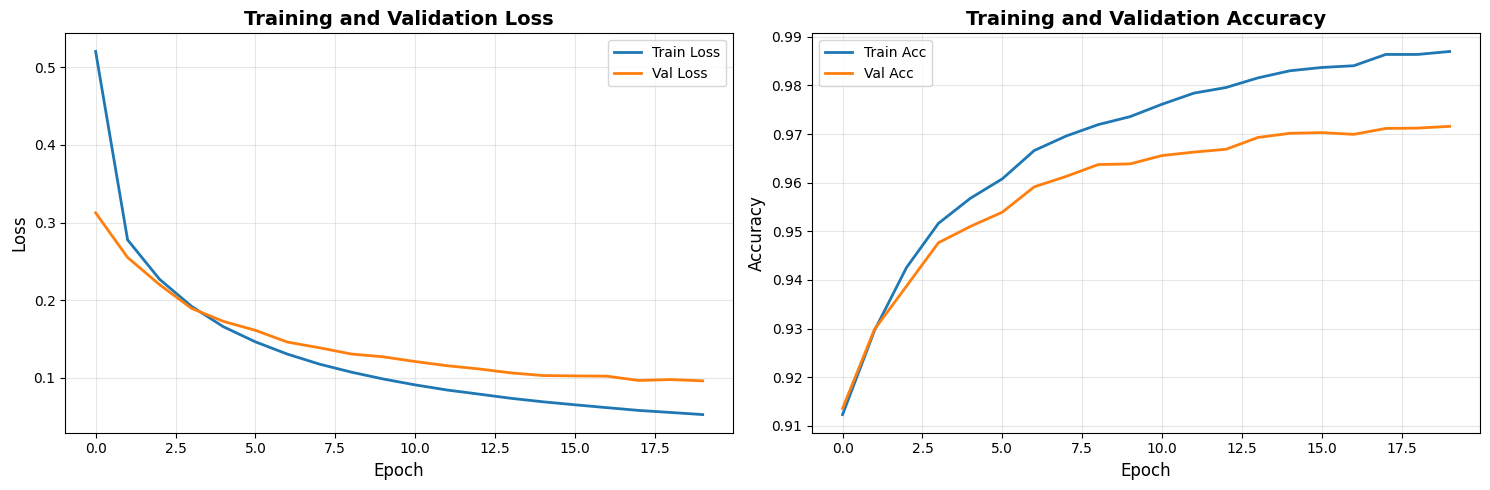

Final Train Accuracy: 0.9870
Final Val Accuracy: 0.9716


In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")

## Step 14: Evaluate on Test Set

In [56]:
A2_test, _ = forward_propagation(X_test, parameters)
y_pred = np.argmax(A2_test, axis=1)

test_acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

✅ Test Accuracy: 97.16%


## Step 15: Visualize Predictions

/tmp/ipython-input-3199213394.py:14: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


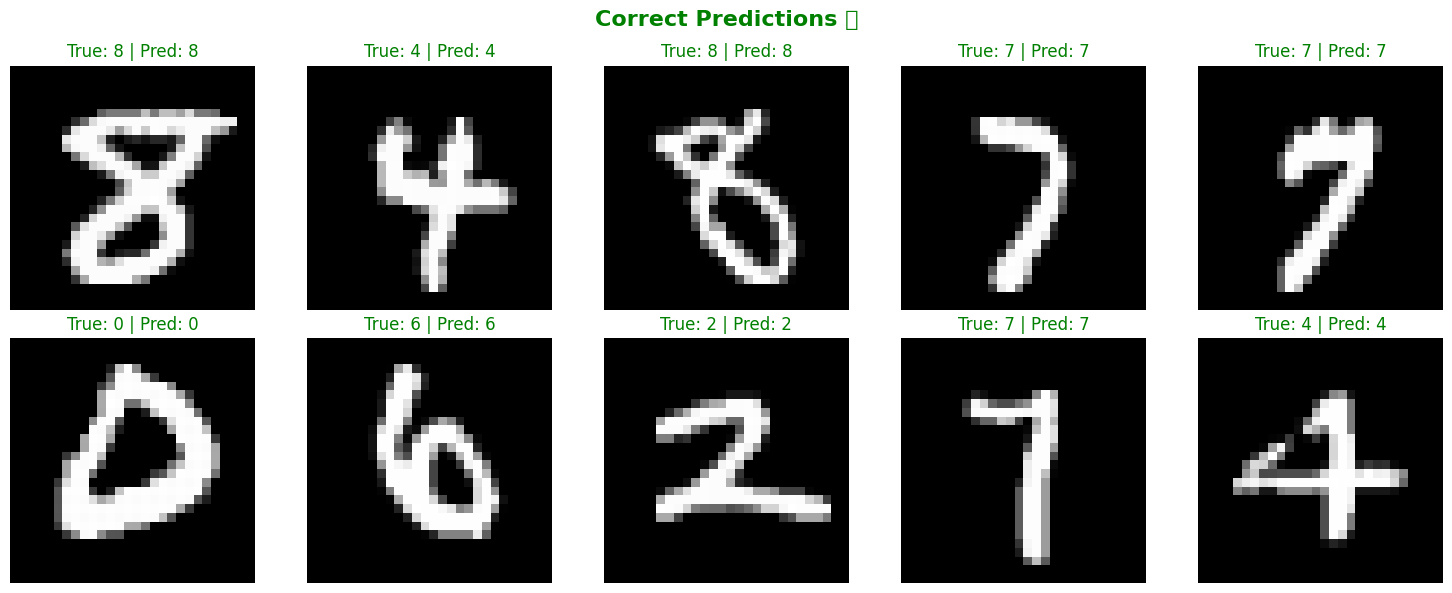

/tmp/ipython-input-3199213394.py:28: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


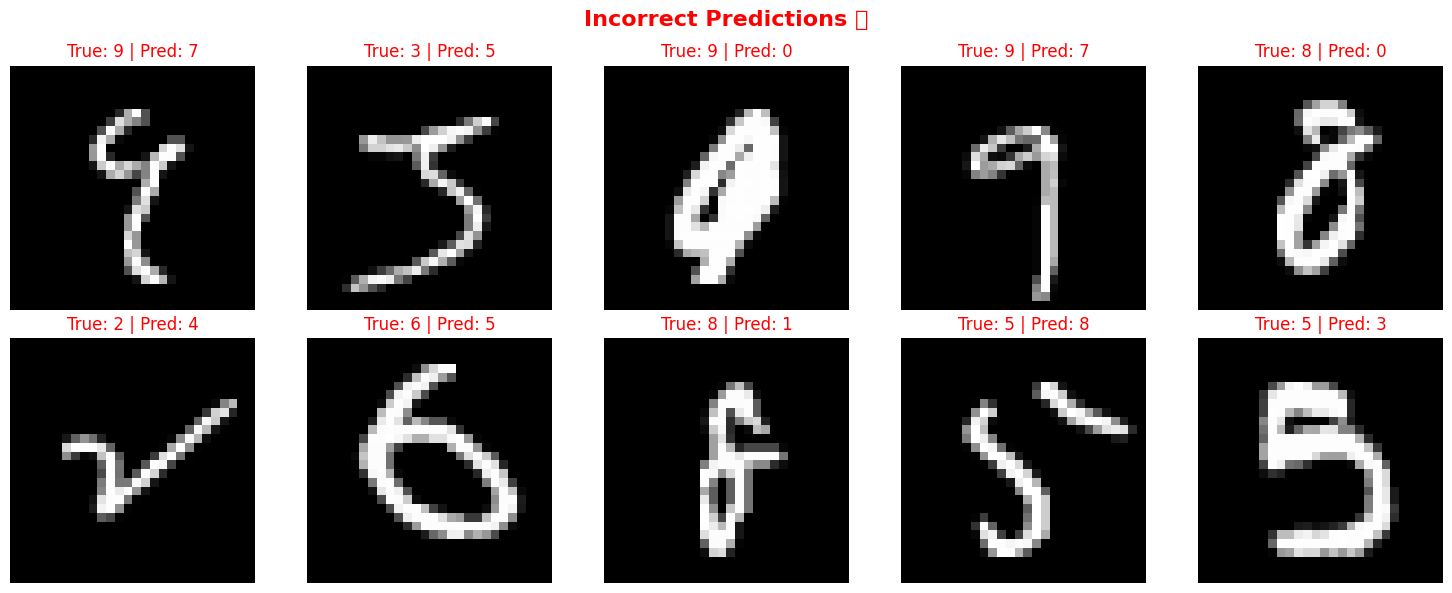

In [57]:
# We've provided you with another way to visualize the predictions made by the NN here!
test_predictions = y_pred

correct_idx = np.where(test_predictions == y_test)[0]
incorrect_idx = np.where(test_predictions != y_test)[0]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Correct Predictions ✅', fontsize=16, fontweight='bold', color='green')
for i, ax in enumerate(axes.flat):
    idx = correct_idx[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'True: {y_test[idx]} | Pred: {test_predictions[idx]}', color='green')
    ax.axis('off')
plt.tight_layout()
plt.show()

if len(incorrect_idx) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Incorrect Predictions ❌', fontsize=16, fontweight='bold', color='red')
    for i, ax in enumerate(axes.flat):
        if i < len(incorrect_idx):
            idx = incorrect_idx[i]
            ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
            ax.set_title(f'True: {y_test[idx]} | Pred: {test_predictions[idx]}', color='red')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

## CONGRATS!!

If you made it this far, you've successfully trained a NN from scratch. This is not a small feat by any means, and geniunely one of the BEST ways you can learn deep learning. Way to go! 🎉